<a href="https://colab.research.google.com/github/fericazatti/CUDA_GPU_INTRODUCTION/blob/main/ICNPG_desafio_FFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*texto en cursiva*# Desafío

Se dispone del módulo y la fase de la transformada de Fourier de una imagen $I(k_x,k_y)$. Es decir, disponemos de $M(k_x,k_y)$ y de $\phi(k_x,k_y)$ de tal forma que

$I(k_x,k_y)=M(k_x,k_y)e^{i \phi(k_x,k_y)}$

Su misión es informar de que se trata la imagen en espacio real $I(x,y)$.


La matriz $M(k_x,k_y)$ está en el archivo binario "magnitude.bin" y $\phi(k_x,k_y)$ en "phase.bin", ambas son de $(720,1200)$ (numpy "shape"). Descargue ambos archivos corriendo lo siguiente



In [1]:
#@ Bajar las imagenes encriptadas
!pip install --upgrade gdown
!gdown --id 1croRr2la8iSV51vVtvJmOJflOU6sg9Fe -O /content/
!gdown --id 1RKvv-q1Kdh8esDMcxxOZbrzmTmSKv_ml -O /content/

#https://drive.google.com/file/d/1croRr2la8iSV51vVtvJmOJflOU6sg9Fe/view?usp=sharing
#https://drive.google.com/file/d/1RKvv-q1Kdh8esDMcxxOZbrzmTmSKv_ml/view?usp=sharing

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1croRr2la8iSV51vVtvJmOJflOU6sg9Fe
To: /content/magnitude.bin
100% 3.46M/3.46M [00:00<00:00, 158MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1RKvv-q1Kdh8esDMcxxOZbrzmTmSKv_ml
To: /content/phase.bin
100% 3.46M/3.46M [00:00<00:00, 165MB/s]


Una vez descargados los binarios en el directorio raiz, podemos visualizar ambos arrays fácilmente usando numpy

* Antes de continuar, descargar los binarios y ponerlos en el directorio raíz


(Text(0.5, 1.0, 'Phase Spectrum'), ([], []), ([], []))

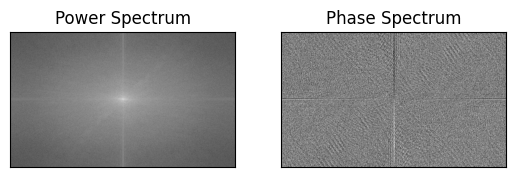

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

pha = np.fromfile('phase.bin', dtype=np.float32)
mag = np.fromfile('magnitude.bin', dtype=np.float32)

shape=(720, 1200)

pha = pha.reshape(shape)
mag = mag.reshape(shape)

plt.subplot(1,2,1), plt.imshow(np.log(mag), cmap='gray')
plt.title('Power Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2), plt.imshow(pha, cmap='gray')
plt.title('Phase Spectrum'), plt.xticks([]), plt.yticks([])

**Notar**
* Las frecuencias fueron shifteadas para que el $(k_x,k_y)=(0,0)$ este en el centro.
* Los datos descargados son float32.

# Solución

* Haciendo las operaciones convenientes, llenar el array de numpy "image" de abajo y visualizarlo con las funciones provistas en el template.

* Usar cupy y numpy.

* Comparar la performance haciendo los cálculos en CPU y en GPU respectivamente.


* Comunicar el resultado a la cátedra.

Elapsed time (NumPy - CPU): 0.060486 seconds
Elapsed time (CuPy - 2D array): 0.004346 seconds
Elapsed time (CuPy - Optimized 1D array): 0.003543 seconds


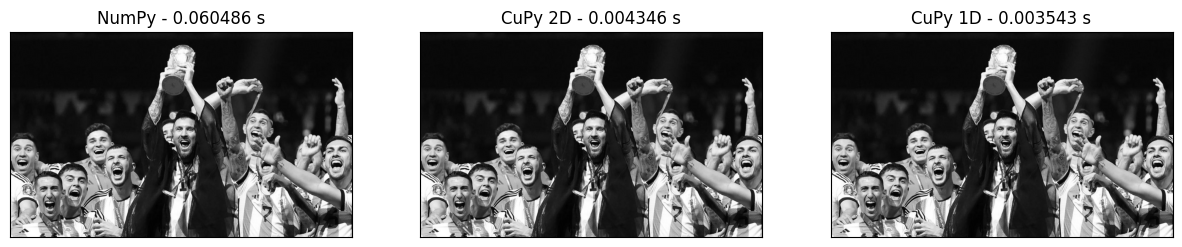

In [27]:
import time
import cupy as cp
import numpy as np
from matplotlib import pyplot as plt

# Cargar los binarios de magnitud y fase
pha = np.fromfile('phase.bin', dtype=np.float32)
mag = np.fromfile('magnitude.bin', dtype=np.float32)

shape = (720, 1200)

pha = pha.reshape(shape)
mag = mag.reshape(shape)

image = np.empty(shape)

# ============================== #
# Solución NumPy (CPU) #
# ============================== #
start_time_numpy = time.time()

# Calcular la transformada inversa de Fourier
combined_data = mag * np.exp(1j * pha)
image_numpy = np.fft.ifft2(np.fft.ifftshift(combined_data)).real

end_time_numpy = time.time()
elapsed_time_numpy = end_time_numpy - start_time_numpy

print(f"Elapsed time (NumPy - CPU): {elapsed_time_numpy:.6f} seconds")

# ============================== #
# Solución CuPy (GPU - Bidimensional) #
# ============================== #
start_time_cupy_2D = time.time()

# Convertir arrays a GPU
gpu_mag_2D = cp.asarray(mag)
gpu_pha_2D = cp.asarray(pha)

# Operaciones en GPU usando datos en 2D
combined_data_gpu_2D = gpu_mag_2D * cp.exp(1j * gpu_pha_2D)
image_gpu_2D = cp.fft.ifft2(cp.fft.ifftshift(combined_data_gpu_2D)).real
image_cupy_2D = cp.asnumpy(image_gpu_2D)  # Convertir de vuelta a NumPy

end_time_cupy_2D = time.time()
elapsed_time_cupy_2D = end_time_cupy_2D - start_time_cupy_2D

print(f"Elapsed time (CuPy - 2D array): {elapsed_time_cupy_2D:.6f} seconds")

# ============================== #
# Solución CuPy Optimizada (GPU - Unidimensional) #
# ============================== #
start_time_cupy_1D = time.time()

# Convertir a unidimensional para optimizar acceso a memoria
gpu_mag_1D = cp.asarray(mag)
gpu_pha_1D = cp.asarray(pha)

# Operación en 1D y luego reshape para 2D
combined_data_gpu_1D = gpu_mag_1D * cp.exp(1j * gpu_pha_1D)
combined_data_gpu_1D = combined_data_gpu_1D.reshape(shape)  # Volver a 2D

# Aplicar la transformada inversa de Fourier
image_gpu_1D = cp.fft.ifft2(cp.fft.ifftshift(combined_data_gpu_1D)).real
image_cupy_1D = cp.asnumpy(image_gpu_1D)  # Convertir de vuelta a NumPy

end_time_cupy_1D = time.time()
elapsed_time_cupy_1D = end_time_cupy_1D - start_time_cupy_1D

print(f"Elapsed time (CuPy - Optimized 1D array): {elapsed_time_cupy_1D:.6f} seconds")

# ============================== #
# Mostrar las imágenes #
# ============================== #
plt.figure(figsize=(15, 5))

# Imagen con NumPy
plt.subplot(1, 3, 1)
plt.imshow(image_numpy, cmap='gray')
plt.title(f'NumPy - {elapsed_time_numpy:.6f} s')
plt.xticks([]), plt.yticks([])

# Imagen con CuPy (2D)
plt.subplot(1, 3, 2)
plt.imshow(image_cupy_2D, cmap='gray')
plt.title(f'CuPy 2D - {elapsed_time_cupy_2D:.6f} s')
plt.xticks([]), plt.yticks([])

# Imagen con CuPy (Optimizado 1D)
plt.subplot(1, 3, 3)
plt.imshow(image_cupy_1D, cmap='gray')
plt.title(f'CuPy 1D - {elapsed_time_cupy_1D:.6f} s')
plt.xticks([]), plt.yticks([])

plt.show()

